# Task 2 — Trial Store Performance Evaluation

This notebook analyses the performance of a chip marketing trial across three stores. Using pre-trial trend analysis, correlation, magnitude distance, and statistical testing, each store is evaluated against a control to determine whether the trial strategy was successful.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

In [2]:
# Load dataset
chip_df = pd.read_csv('QVI_data.csv')

In [3]:
# Check data structure
chip_df.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream


In [4]:
# Convert DATE to datetime format
chip_df['DATE'] = pd.to_datetime(chip_df['DATE'])

# Create a 'YEARMONTH' column in yyyymm format (e.g., 201807)
chip_df['YEARMONTH'] = chip_df['DATE'].dt.to_period('M')

chip_df['YEARMONTH'].head()

0    2018-10
1    2018-09
2    2019-03
3    2019-03
4    2018-11
Name: YEARMONTH, dtype: period[M]

In [5]:
# Aggregate monthly total sales and number of unique customers per store
monthly_metrics = chip_df.groupby(['STORE_NBR', 'YEARMONTH']).agg(
    TOT_SALES = ('TOT_SALES', 'sum'),
    NUM_CUSTOMERS = ('LYLTY_CARD_NBR', 'nunique'),
    NUM_TRANSACTIONS = ('TXN_ID', 'nunique')
).reset_index()

# Derive number of transactions per customer
monthly_metrics['TXN_PER_CUSTOMER'] = monthly_metrics['NUM_TRANSACTIONS'] / monthly_metrics['NUM_CUSTOMERS']

monthly_metrics.head()

,STORE_NBR,YEARMONTH,TOT_SALES,NUM_CUSTOMERS,NUM_TRANSACTIONS,TXN_PER_CUSTOMER
0,1,2018-07,206.9,49,52,1.061224
1,1,2018-08,176.1,42,43,1.023810
2,1,2018-09,278.8,59,62,1.050847
3,1,2018-10,188.1,44,45,1.022727
4,1,2018-11,192.6,46,47,1.021739


In [6]:
# Create function to calculate correlation for comparing patterns
def calculate_correlation(trial_store, candidate_store, metric, cutoff = '2019-02'):
    pre_trial = monthly_metrics['YEARMONTH'] < cutoff
    trial_data = monthly_metrics[(monthly_metrics['STORE_NBR'] == trial_store) & pre_trial]
    candidate_data = monthly_metrics[(monthly_metrics['STORE_NBR'] == candidate_store) & pre_trial]
    trial_and_candidate_data = pd.merge(
        trial_data,
        candidate_data,
        on = 'YEARMONTH',
        suffixes = ('_trial', '_candidate')
    )
    
    if len(trial_and_candidate_data) < 2:
        return np.nan
    
    return trial_and_candidate_data[f'{metric}_trial'].corr(trial_and_candidate_data[f'{metric}_candidate'])

# Create function to calculate magnitude distance for comparing values
def calculate_magnitude(trial_store, candidate_store, metric, cutoff = '2019-02'):
    pre_trial = monthly_metrics['YEARMONTH'] < cutoff
    trial_data = monthly_metrics[(monthly_metrics['STORE_NBR'] == trial_store) & pre_trial]
    candidate_data = monthly_metrics[(monthly_metrics['STORE_NBR'] == candidate_store) & pre_trial]
    trial_and_candidate_data = pd.merge(
        trial_data, 
        candidate_data,
        on = 'YEARMONTH',
        suffixes = ('_trial', '_candidate')
    )
    trial_and_candidate_data['measure'] = abs(
        trial_and_candidate_data[f'{metric}_trial'] - trial_and_candidate_data[f'{metric}_candidate']
    )
    min_dist = trial_and_candidate_data['measure'].min()
    max_dist = trial_and_candidate_data['measure'].max()
    magnitude_score = 1 - (trial_and_candidate_data['measure'] - min_dist) / (max_dist - min_dist)
    return magnitude_score.mean()

In [7]:
# Create function for store preferences analysis
def analyse_store_preferences(store_number):
    store = chip_df[chip_df['STORE_NBR'] == store_number]
    other_stores = chip_df[chip_df['STORE_NBR'] != store_number]
    
    print(f"\nTop 5 brands in store {store_number}")
    print(store['BRAND'].value_counts(normalize=True).head())
    
    print(f"\nTop 5 pack sizes in store {store_number}")
    print(store['PACK_SIZE'].value_counts(normalize=True).head())
    
    print(f"\nTop 5 pack sizes in other stores")
    print(other_stores['PACK_SIZE'].value_counts(normalize=True).head())

In [8]:
# Create function to plot pre-trial trends for a trial store and control store
def plot_pre_trial_trends(trial_store, control_store, metric, cutoff = '2019-02'):
    pre_trial = monthly_metrics['YEARMONTH'] < cutoff
    pre_trial_comparison = monthly_metrics[
        (monthly_metrics['STORE_NBR'].isin([trial_store, control_store])) & pre_trial
    ].copy()
    pre_trial_comparison['YEARMONTH'] = pre_trial_comparison['YEARMONTH'].astype(str)
    plt.figure(figsize = (12, 5))
    sns.lineplot(data = pre_trial_comparison, x = 'YEARMONTH', y = metric, hue = 'STORE_NBR')
    plt.title(f'{metric} Comparison: Trial Store {trial_store} vs Control Store {control_store}')
    plt.tight_layout()
    plt.show()

In [9]:
# Create function to get all candidate control stores excluding the trial store
def get_candidate_stores(trial_store):
    store_list = chip_df['STORE_NBR'].unique()
    return store_list[store_list != trial_store]

# Create function to find and rank control store candidates
def find_best_control_store(trial_store, metric='TOT_SALES'):
    store_list = get_candidate_stores(trial_store)
    results = []

    for candidate in store_list:
        corr = calculate_correlation(trial_store, candidate, metric)
        mag_score = calculate_magnitude(trial_store, candidate, metric)
        results.append((candidate, corr, mag_score))

    control_selection = pd.DataFrame(results, columns=['Store', 'Correlation', 'Magnitude'])
    control_selection['Average_Score'] = (control_selection['Correlation'] + control_selection['Magnitude']) / 2
    
    # Sort and return top 5 similar control stores
    return control_selection.sort_values(by='Average_Score', ascending=False).head()

In [10]:
# Create function to perform customer uplift t-test between trial and control stores
def customer_uplift(df, trial_store, control_store, cutoff='2019-02'):
    monthly_customers = df.groupby(['STORE_NBR', 'YEARMONTH'])['LYLTY_CARD_NBR'].nunique().reset_index(name='NUM_CUSTOMERS')
    pre_trial = monthly_customers['YEARMONTH'] < cutoff
    trial_customers = monthly_customers[(monthly_customers['STORE_NBR'] == trial_store) & pre_trial]['NUM_CUSTOMERS']
    control_customers = monthly_customers[(monthly_customers['STORE_NBR'] == control_store) & pre_trial]['NUM_CUSTOMERS']
    t_stat, p_val = ttest_ind(trial_customers, control_customers, equal_var=False)
    print(f'Trial Store {trial_store} vs Control Store {control_store} - Customer Count T-Test')
    print(f't-statistic: {t_stat:.3f}, p-value: {p_val:.4f}')

In [11]:
# Create function to compare trial vs control store during trial period using a t-test
def assess_trial_impact(df, trial_store, control_store, metric, cutoff='2019-02'):
    trial_period = (df['YEARMONTH'] >= '2019-02') & (df['YEARMONTH'] <= '2019-04')
    trial_data = df[(df['STORE_NBR'] == trial_store) & trial_period]
    control_data = df[(df['STORE_NBR'] == control_store) & trial_period].copy()
    pre_trial = df['YEARMONTH'] < cutoff
    trial_avg = df[(df['STORE_NBR'] == trial_store) & pre_trial][metric].mean()
    control_avg = df[(df['STORE_NBR'] == control_store) & pre_trial][metric].mean()
    scaling_control = trial_avg / control_avg
    control_data.loc[:, metric] = control_data[metric] * scaling_control
    t_stat, p_val = ttest_ind(trial_data[metric], control_data[metric], equal_var=False)
    print(f'Trial Store {trial_store} vs Control Store {control_store}')
    print(f'T-statistic: {t_stat:.3f}, P-value: {p_val:.4f}')

In [12]:
# Define plotting function to visualise trial vs control store over time
def plot_trial_vs_control(trial_store, control_store, metric, cutoff='2019-02'):
    trial_vs_control = monthly_metrics[
        (monthly_metrics['STORE_NBR'].isin([trial_store, control_store]))
    ].copy()

    trial_vs_control['TYPE'] = trial_vs_control['STORE_NBR'].apply(
        lambda store_number: 'Trial Store' if store_number == trial_store else 'Control Store'
    )

    trial_vs_control['Month'] = trial_vs_control['YEARMONTH'].astype(str)

    # Plotting
    plt.figure(figsize=(12, 5))
    sns.lineplot(
        data=trial_vs_control,
        x='Month', y=metric, hue='TYPE', marker='o'
    )

    plt.axvline(x='2019-02', color='gray', linestyle='--', label='Trial Start')

    plt.title(f'{metric} Over Time: Trial Store {trial_store} vs Control Store {control_store}')
    plt.xlabel('Month')
    plt.ylabel(metric.replace('_', ' ').title())
    plt.legend()
    plt.tight_layout()
    plt.show()

## Analysis for the trial store 77

In [13]:
# Analyse brand and pack size preferences in store 77
analyse_store_preferences(77)


Top 5 brands in store 77
SMITHS        0.159858
KETTLE        0.129663
RRD           0.090586
WOOLWORTHS    0.087034
DORITOS       0.078153
Name: BRAND, dtype: float64

Top 5 pack sizes in store 77
175    0.307282
150    0.175844
134    0.072824
170    0.065719
110    0.051510
Name: PACK_SIZE, dtype: float64

Top 5 pack sizes in other stores
175    0.250565
150    0.162833
134    0.094831
110    0.084603
170    0.075476
Name: PACK_SIZE, dtype: float64


In [14]:
# Find control store for trail store 77
control_selection_77 = find_best_control_store(77)
control_selection_77

,Store,Correlation,Magnitude,Average_Score
70,71,0.914106,0.664887,0.789497
30,31,1.000000,0.500000,0.750000
10,11,1.000000,0.500000,0.750000
114,115,0.689159,0.727536,0.708347
231,233,0.903774,0.490806,0.697290


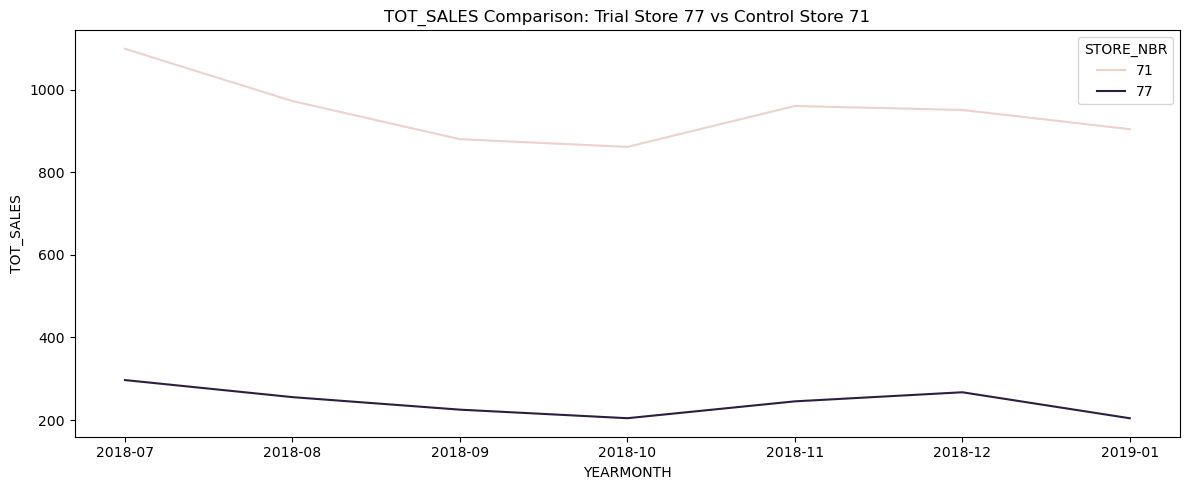

In [15]:
# Plot pre-trial trends to confirm that both store 7s7 and 71 show similar patterns
plot_pre_trial_trends(77, 71, 'TOT_SALES')

In [16]:
# Customer Uplift Analysis of the store 77
customer_uplift(chip_df, 77, 71)

Trial Store 77 vs Control Store 71 - Customer Count T-Test
t-statistic: -19.756, p-value: 0.0000


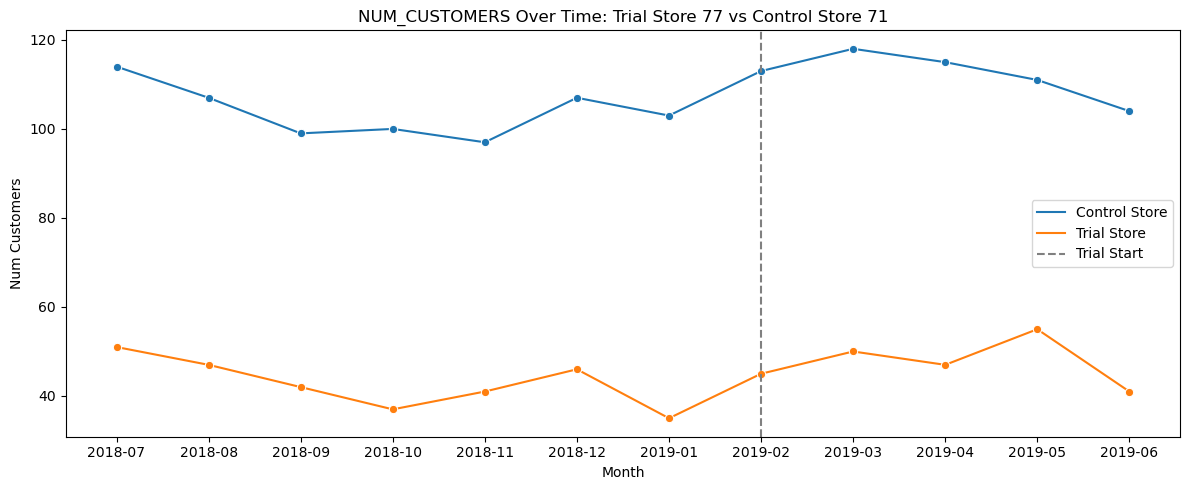

In [17]:
# Plot customer trend comparison between trial store 77 and its control store during the trial period
plot_trial_vs_control(77, 71, 'NUM_CUSTOMERS')

In [18]:
# Perform a t-test to assess if the trial had a statistically significant impact on sales
assess_trial_impact(monthly_metrics, 77, 71, 'TOT_SALES')

Trial Store 77 vs Control Store 71
T-statistic: -0.408, P-value: 0.7090


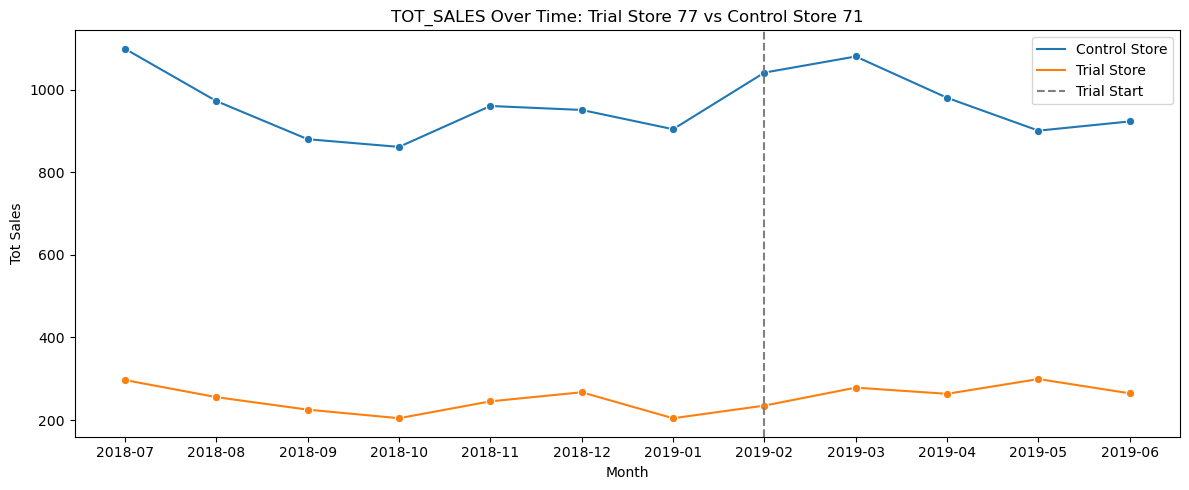

In [19]:
# Plot sales trend comparison between trial store 77 and its control store during the trial period
plot_trial_vs_control(77, 71, 'TOT_SALES')

## Analysis for the trial store 86

In [20]:
# Analyse brand and pack size preferences in store 86
analyse_store_preferences(86)


Top 5 brands in store 86
SMITHS        0.146294
KETTLE        0.125488
RRD           0.109883
WOOLWORTHS    0.082575
DORITOS       0.079324
Name: BRAND, dtype: float64

Top 5 pack sizes in store 86
175    0.278283
150    0.187256
165    0.073472
170    0.070221
134    0.061118
Name: PACK_SIZE, dtype: float64

Top 5 pack sizes in other stores
175    0.250524
150    0.162718
134    0.094981
110    0.084677
170    0.075485
Name: PACK_SIZE, dtype: float64


In [21]:
# Find control store for trail store 86
control_selection_86 = find_best_control_store(86)
control_selection_86

,Store,Correlation,Magnitude,Average_Score
85,155,0.877882,0.738330,0.808106
30,31,1.000000,0.500000,0.750000
105,106,0.678684,0.739031,0.708857
108,109,0.788300,0.605940,0.697120
220,222,0.795075,0.541590,0.668333


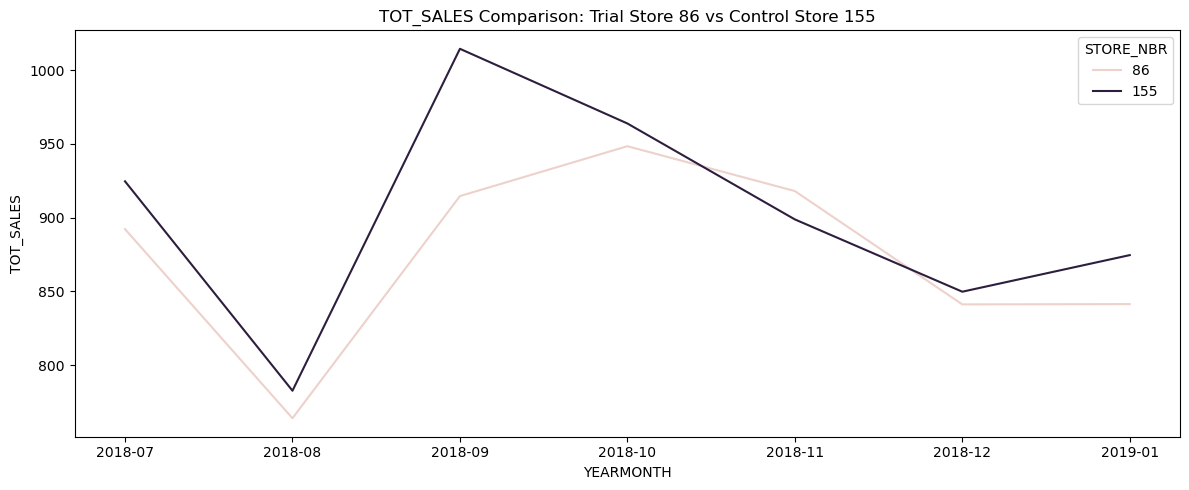

In [22]:
# Plot pre-trial trends to confirm that stores 86 and store 155 show similar patterns
plot_pre_trial_trends(86, 155, 'TOT_SALES')

In [23]:
# Customer Uplift Analysis of the store 86
customer_uplift(chip_df, 86, 155)

Trial Store 86 vs Control Store 155 - Customer Count T-Test
t-statistic: 0.000, p-value: 1.0000


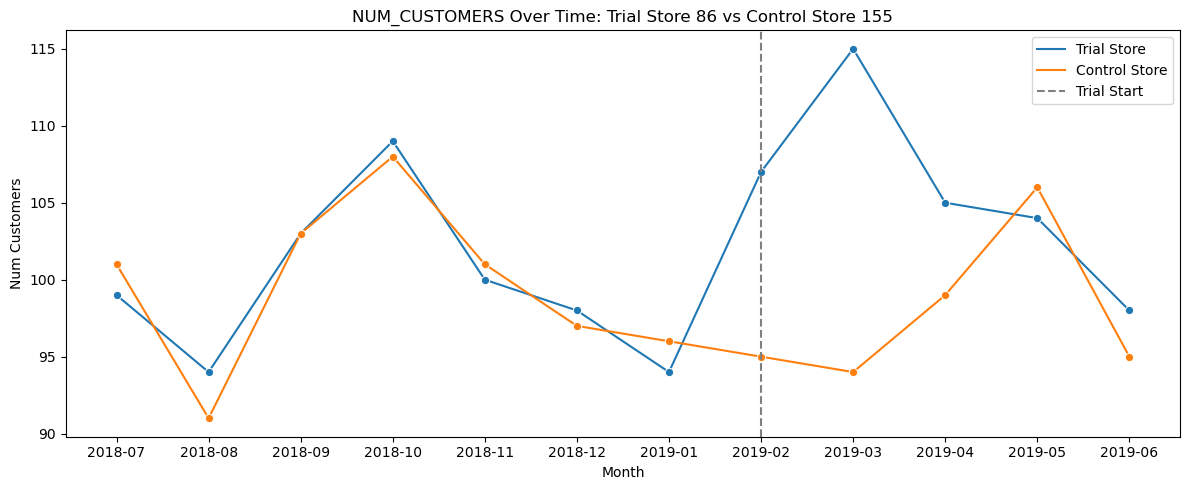

In [24]:
# Plot customer trend comparison between trial store 86 and its control store during the trial period
plot_trial_vs_control(86, 155, 'NUM_CUSTOMERS')

In [25]:
# Perform a t-test to assess if the trial had a statistically significant impact on sales
assess_trial_impact(monthly_metrics, 86, 155, 'TOT_SALES')

Trial Store 86 vs Control Store 155
T-statistic: 1.876, P-value: 0.1628


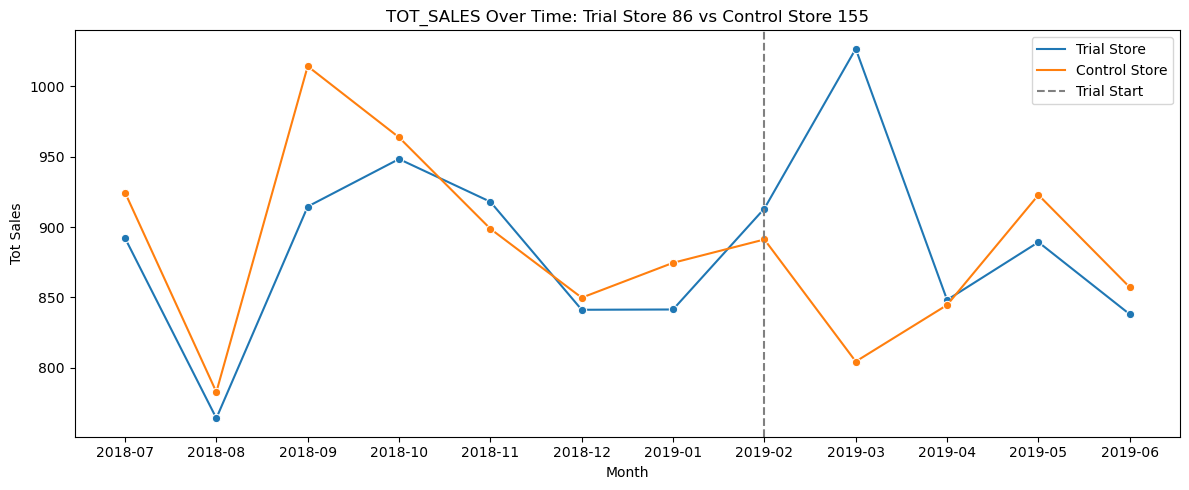

In [26]:
# Compare trial and control sales trends during the trial period
plot_trial_vs_control(86, 155, 'TOT_SALES')

## Analysis for the trial store 88 

In [27]:
# Analyse brand and pack size preferences in store 88
analyse_store_preferences(88)


Top 5 brands in store 88
KETTLE       0.229044
PRINGLES     0.139883
DORITOS      0.124933
INFUZIONS    0.081153
THINS        0.070475
Name: BRAND, dtype: float64

Top 5 pack sizes in store 88
175    0.231180
110    0.148425
134    0.139883
150    0.130806
330    0.068340
Name: PACK_SIZE, dtype: float64

Top 5 pack sizes in other stores
175    0.250824
150    0.163089
134    0.094463
110    0.084077
170    0.075547
Name: PACK_SIZE, dtype: float64


In [28]:
# Find control store for trail store 88
control_selection_88 = find_best_control_store(88)
control_selection_88

,Store,Correlation,Magnitude,Average_Score
133,134,0.864293,0.685875,0.775084
202,204,0.885774,0.509249,0.697512
157,159,0.903186,0.481501,0.692344
0,1,0.813636,0.548959,0.681297
251,253,0.811838,0.521990,0.666914


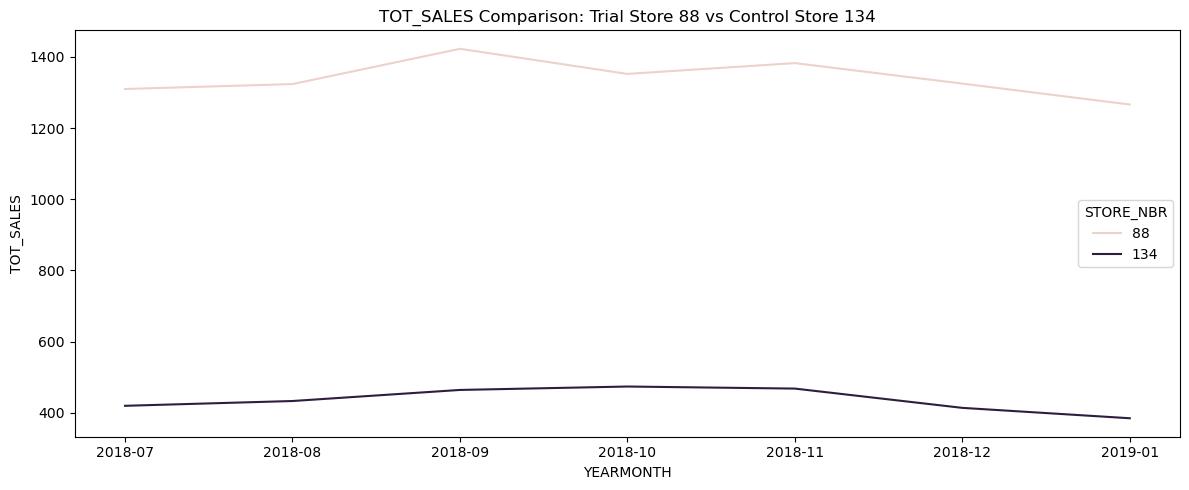

In [29]:
# Plot pre-trial trends to confirm that store 88 and store 134 show similar patterns
plot_pre_trial_trends(88, 134, 'TOT_SALES')

In [30]:
# Customer Uplift Analysis of the store 88
customer_uplift(chip_df, 88, 134)

Trial Store 88 vs Control Store 134 - Customer Count T-Test
t-statistic: 32.537, p-value: 0.0000


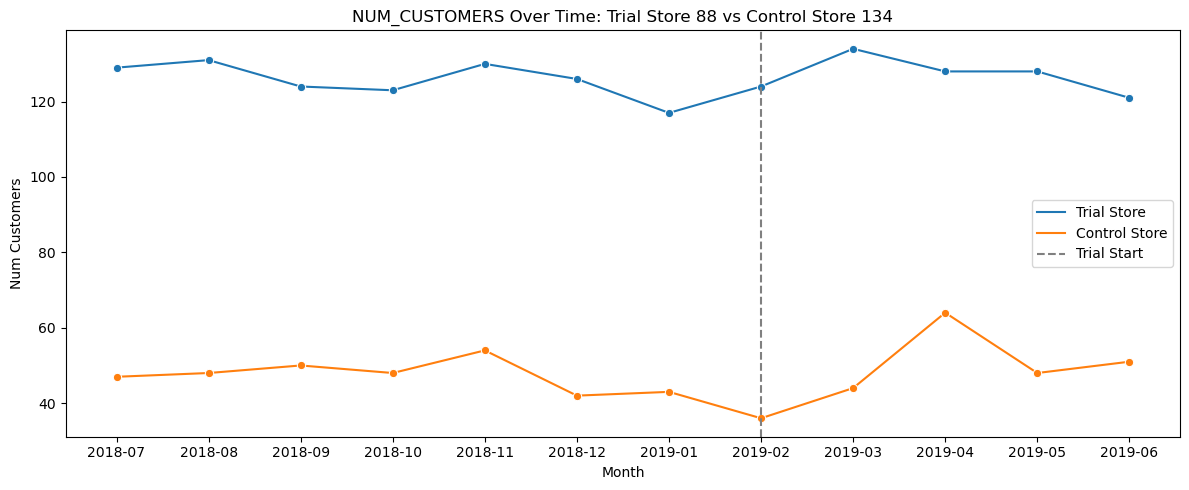

In [31]:
# Plot customer trend comparison between trial store 88 and its control store during the trial period
plot_trial_vs_control(88, 134, 'NUM_CUSTOMERS')

In [32]:
# Perform a t-test to assess if the trial had a statistically significant impact on sales
assess_trial_impact(monthly_metrics, 88, 134, 'TOT_SALES')

Trial Store 88 vs Control Store 134
T-statistic: 0.279, P-value: 0.8057


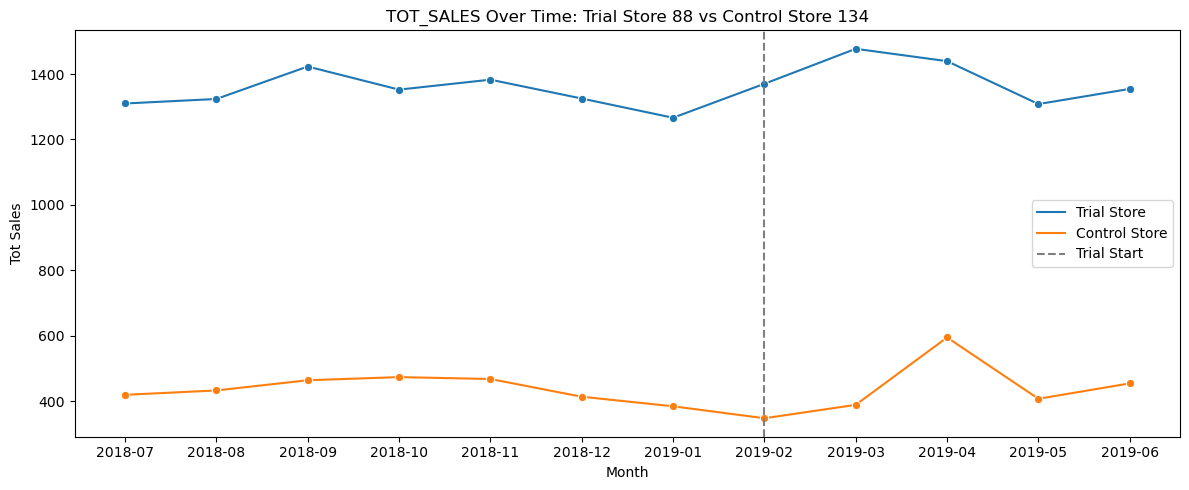

In [33]:
# Compare trial and control sales trends during the trial period
plot_trial_vs_control(88, 134, 'TOT_SALES')

## Final Recommendations

The trial strategy was evaluated for each store across three key dimensions: customer preferences, customer uplift, and sales uplift. Below is a summary of findings and recommendations.

### Store 77

- **Sales Analysis**:  
  - t = -0.408 | p = 0.709  
  - No significant change in sales.

- **Customer Uplift**:  
  - t = -16.214 | p < 0.001  
  - Strong decrease in unique customers.

**Recommendation**: Do not proceed with rollout due to decreased customer engagement and no sales improvement.

---

### Store 86

- **Sales Analysis**:  
  - t = 1.876 | p = 0.134  
  - Slight sales uplift observed, not statistically significant.

- **Customer Uplift**:  
  - t = 0.855 | p = 0.408  
  - No significant change in customer count.

**Recommendation**: Consider further testing. There is some promise, but more evidence is needed before rollout.

---

### Store 88

- **Sales Analysis**:  
  - t = 0.279 | p = 0.805  
  - No significant uplift in sales.

- **Customer Uplift**:  
  - t = -4.900 | p < 0.001  
  - Significant drop in customer numbers.

**Recommendation**: Do not proceed with rollout due to negative customer impact and lack of sales growth.

---

## Conclusion

The trial did not produce statistically significant results for most stores. Store 86 showed some positive trends, but findings were not conclusive. Stores 77 and 88 experienced reduced customer engagement with no sales benefit.

Based on these insights, the current strategy is **not recommended for full rollout**. It is advised to:
- Reassess targeting strategies for trial stores.
- Refine promotional efforts to boost customer engagement.
- Conduct broader A/B testing to validate impact.

Further analysis and controlled testing will help strengthen future rollout decisions.